In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/drive/MyDrive/deteksinew.zip'

# Directory to extract the contents
extracted_dir = '/content/'

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print(f"Successfully extracted contents to {extracted_dir}")

Successfully extracted contents to /content/


In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
!pip install tensorflow

In [ ]:
# Tensorflow Libraries
!pip install Keras-Preprocessing
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00


In [ ]:
# System libraries
from pathlib import Path
import os.path

In [ ]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-07-16 19:08:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-16 19:08:26 (61.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [ ]:
# Walk through each directory
dataset = "/content/deteksinew/TRAIN"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/content/deteksinew/TRAIN'.
There are 0 directories and 720 images in '/content/deteksinew/TRAIN/kaleng'.
There are 0 directories and 720 images in '/content/deteksinew/TRAIN/botol'.


In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

Filepath   Label
0     /content/deteksinew/TRAIN/kaleng/20240628_2014...  kaleng
1     /content/deteksinew/TRAIN/kaleng/20240624_2029...  kaleng
2     /content/deteksinew/TRAIN/kaleng/20240628_2010...  kaleng
3     /content/deteksinew/TRAIN/kaleng/20240628_2015...  kaleng
4     /content/deteksinew/TRAIN/kaleng/20240310_1527...  kaleng
...                                                 ...     ...
1435  /content/deteksinew/TRAIN/botol/20240714_23350...   botol
1436  /content/deteksinew/TRAIN/botol/20240310_15102...   botol
1437  /content/deteksinew/TRAIN/botol/20240310_15061...   botol
1438  /content/deteksinew/TRAIN/botol/20240624_20161...   botol
1439  /content/deteksinew/TRAIN/botol/20240310_15230...   botol

[1440 rows x 2 columns]

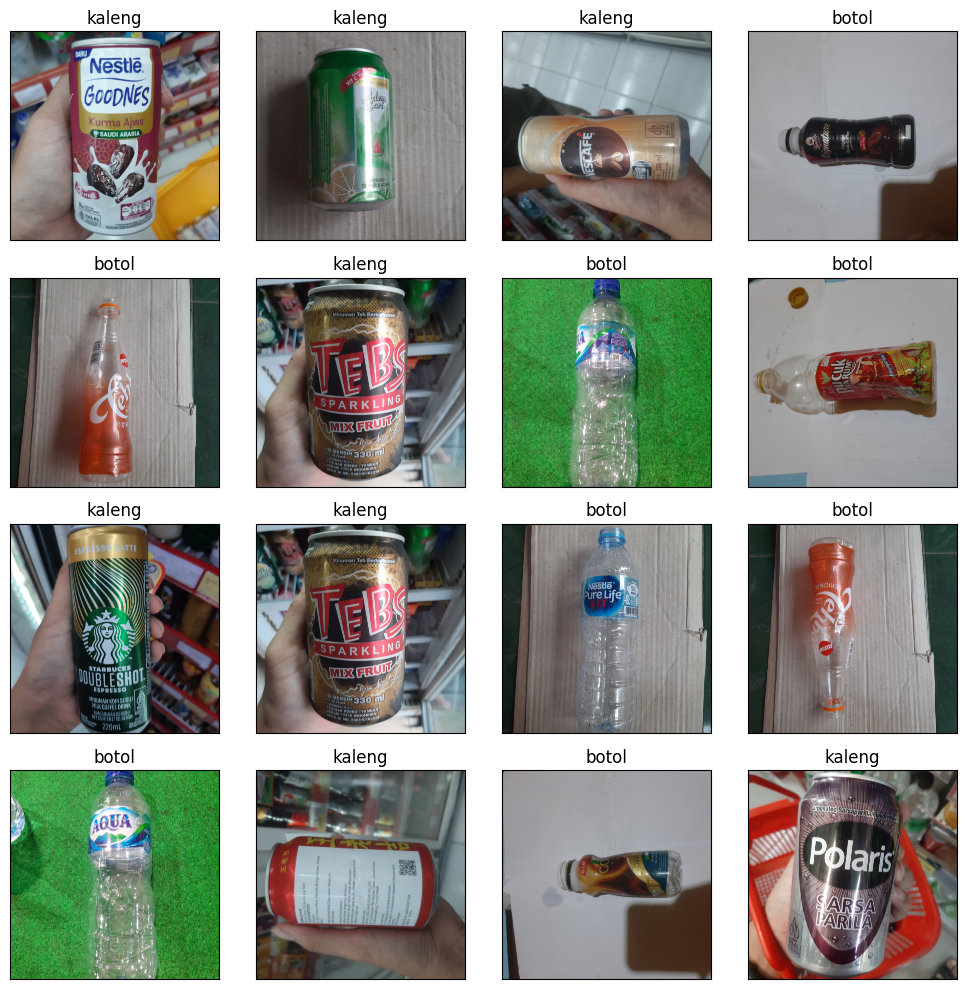

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 922 validated image filenames belonging to 2 classes.
Found 230 validated image filenames belonging to 2 classes.
Found 288 validated image filenames belonging to 2 classes.


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "bottles_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "bottle_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/bottle_classification/20240716-190955
Epoch 1/10
29/29 [==============================] - 154s 5s/step - loss: 0.4668 - accuracy: 0.7874 - val_loss: 0.1323 - val_accuracy: 0.9957
Epoch 2/10
29/29 [==============================] - 123s 4s/step - loss: 0.1076 - accuracy: 0.9805 - val_loss: 0.0475 - val_accuracy: 1.0000
Epoch 3/10
29/29 [==============================] - 124s 4s/step - loss: 0.0512 - accuracy: 0.9892 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 4/10
29/29 [==============================] - 120s 4s/step - loss: 0.0268 - accuracy: 0.9978 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 5/10
29/29 [==============================] - 144s 5s/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 6/10
29/29 [==============================] - 119s 4s/step - loss: 0.0126 - accuracy: 0.9978 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 7/10
29/29 [==============================] - 124s 4s/step - lo

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00183
Test Accuracy: 100.00%


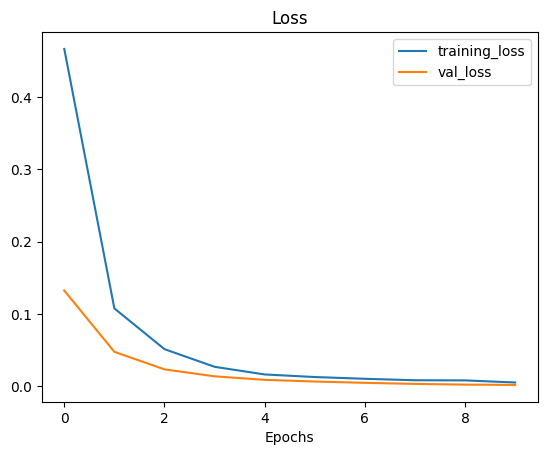

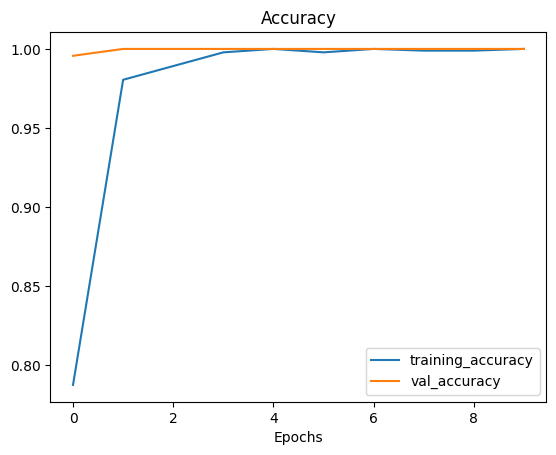

In [ ]:
plot_loss_curves(history)

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

9/9 [==============================] - 31s 3s/step
The first 5 predictions: ['kaleng', 'kaleng', 'kaleng', 'kaleng', 'kaleng']


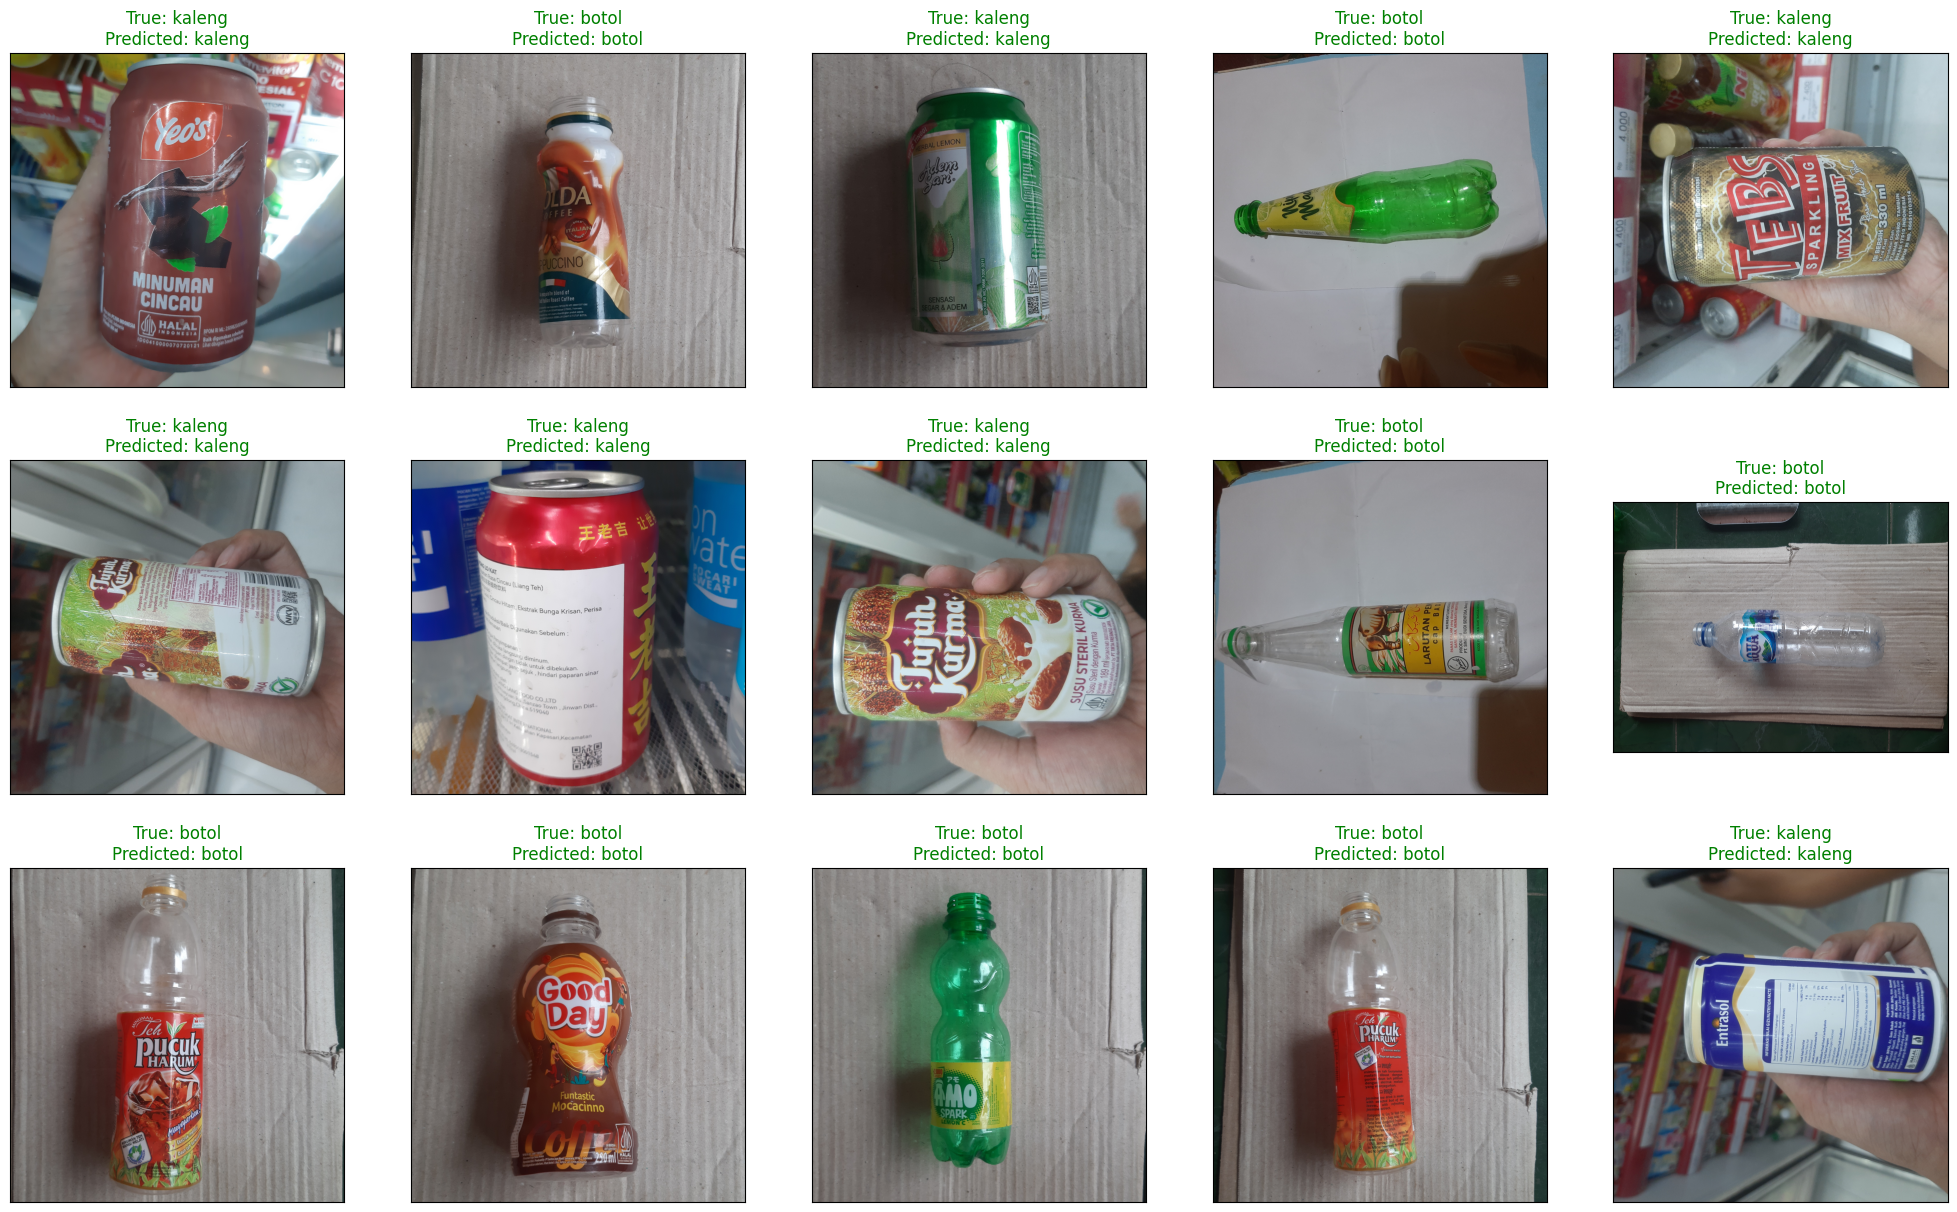

<Figure size 640x480 with 0 Axes>

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       botol       1.00      1.00      1.00       145
      kaleng       1.00      1.00      1.00       143

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision  recall  f1-score  support
botol               1.0     1.0       1.0    145.0
kaleng              1.0     1.0       1.0    143.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    288.0
weighted avg        1.0     1.0       1.0    288.0

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


# New Section

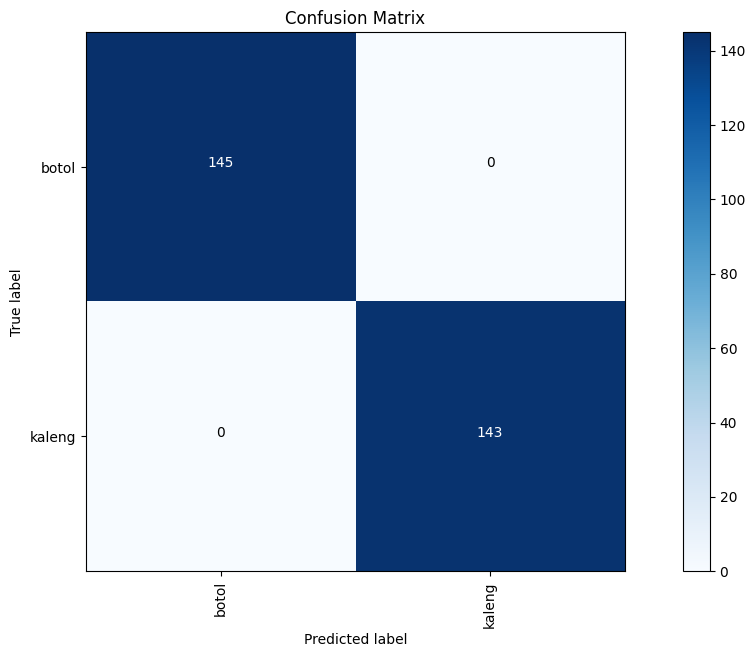

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [ ]:
model_name = model.input_names[0][:-6]
subject = 'AI'
acc = results[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as i-AI-100.00.h5
weights were saved as i-AI-weights.h5


In [ ]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.15.0


In [ ]:
model.save('my_model.keras')

In [ ]:
from tensorflow.keras.preprocessing import image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Function to predict the class of an image
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions, axis=1)[0]
    confidence = predictions[0][class_index]
    if confidence > 0.20:
        print(f'Predicted class: {class_labels[class_index]}')
        print(f'Class probabilities: {predictions[0]}')
    else:
        print('Prediction confidence is too low.')
    return class_index, predictions

In [ ]:
# Dictionary to map class indices to class names
class_labels = {0: 'Botol', 1: 'Kaleng'}
print(f"TensorFlow version: {tf.__version__}")
# Predict on a new image
img_path = 'kkk.jpg'  # Replace with the path to your image
class_index, predictions = predict_image(img_path)

TensorFlow version: 2.15.0
1/1 [==============================] - 4s 4s/step
Predicted class: Kaleng
Class probabilities: [0.41373304 0.586267  ]


In [ ]:
!python --version

Python 3.10.12
